# Assignment #1 

### Group 4

Lars Wrede, Dennis Blaufuss, Nicolas Kepper, Sophie Merl, Philipp Voit
___

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs, make_classification, fetch_20newsgroups_vectorized, fetch_olivetti_faces
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as util_shuffle
import numbers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore') # in case dim is to small

## Principal Component Disasters
Create labeled surrogate data sets. Perform a PCA/Class prediction with ovr logistic regression analysis as developed in the lecture.
___

**(a) 4 blobs: Create clearly separable 4-blobs in 3d but also a ’disaster’ realization with strong overlaps. Study, show and compare elbow plots and prediction boundaries.**

Every plot must be followed by a small take home message.


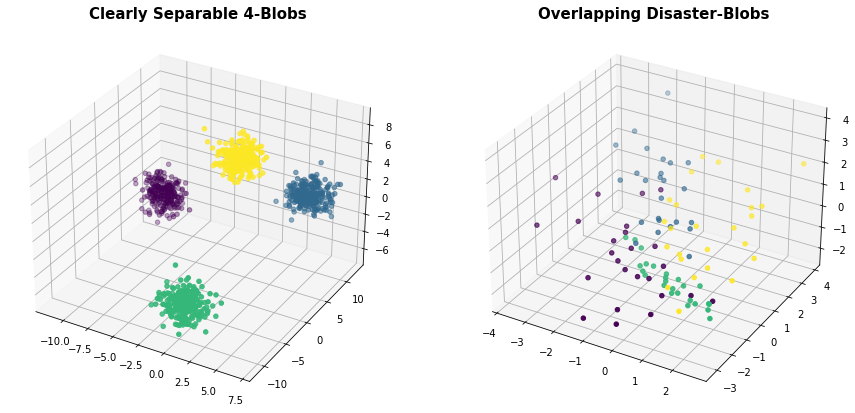

In [2]:
'''In this first part we create the surrogate data sets. To make the comparability easier, 
we always plot the data and our calculations next to each other'''

# Creates 4 blobs
X, y = make_blobs(n_samples = 1000, centers = 4, n_features = 3, random_state = 7) 
# Create overlapping data
X1, y1 = make_classification(n_features = 3, n_redundant = 1, n_informative = 2,
                             n_clusters_per_class = 1, n_classes = 4, random_state = 0)

# Plotting the plots
fig = plt.figure(figsize=(15,10)) # Plot size
'''First Plot'''
ax = fig.add_subplot(1, 2, 1, projection='3d') # Add first plot column
ax.set_title('Clearly Separable 4-Blobs', loc = 'center', fontsize = 15, fontweight = "bold")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = y)
'''Second Plot'''
ax = fig.add_subplot(1, 2, 2, projection='3d') # Add second plot columnm
ax.set_title('Overlapping Disaster-Blobs', loc = 'center', fontsize = 15, fontweight = "bold")
ax.scatter(X1[:, 0], X1[:, 1], X1[:, 2], c = y1)
plt.show()

In [3]:
''' This function calculates the variance of y that is getting explained by X 
as well as the PCA space.'''

def expVariance_pcaSpace(X, y):
    # Split into training and testing sets for BOTH datasets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=0)

    # Standardize the features (zero mean, unit variance) 
    sc = StandardScaler()

    # Fit results must be used later (mu and sigma)
    X_train_std = sc.fit_transform(X_train) 

    # Normalize test data set with mu/sigma of training data
    X_test_std = sc.transform(X_test)

    # Compute covariance matrix and eigenvalues (EVal) / eigenvectors (EVec)
    cov_mat = np.cov(X_train_std.T) #cov matrix from data
    EVal, EVec = np.linalg.eig(cov_mat)

    # Calculate (sum of) explained variances
    sum_EVal = sum(EVal)
    var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]
    
    # Set up PCA and logistic regression model
    pca = PCA(n_components=2)
    lr = LogisticRegression(multi_class='ovr', solver='liblinear')

    # Fit and transform training data, given on PCA reduction to k(=2) principle components
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    # solves task, given 3 classes (as from y_train) 
    lr.fit(X_train_pca, y_train) 
    
    return(var_exp, X_train_pca, X_test_pca, y_train, y_test, lr)

var_exp, X_train_pca, X_test_pca, y_train, y_test, lr = expVariance_pcaSpace(X, y)
var_exp1, X1_train_pca, X1_test_pca, y1_train, y1_test, lr1 = expVariance_pcaSpace(X1, y1)

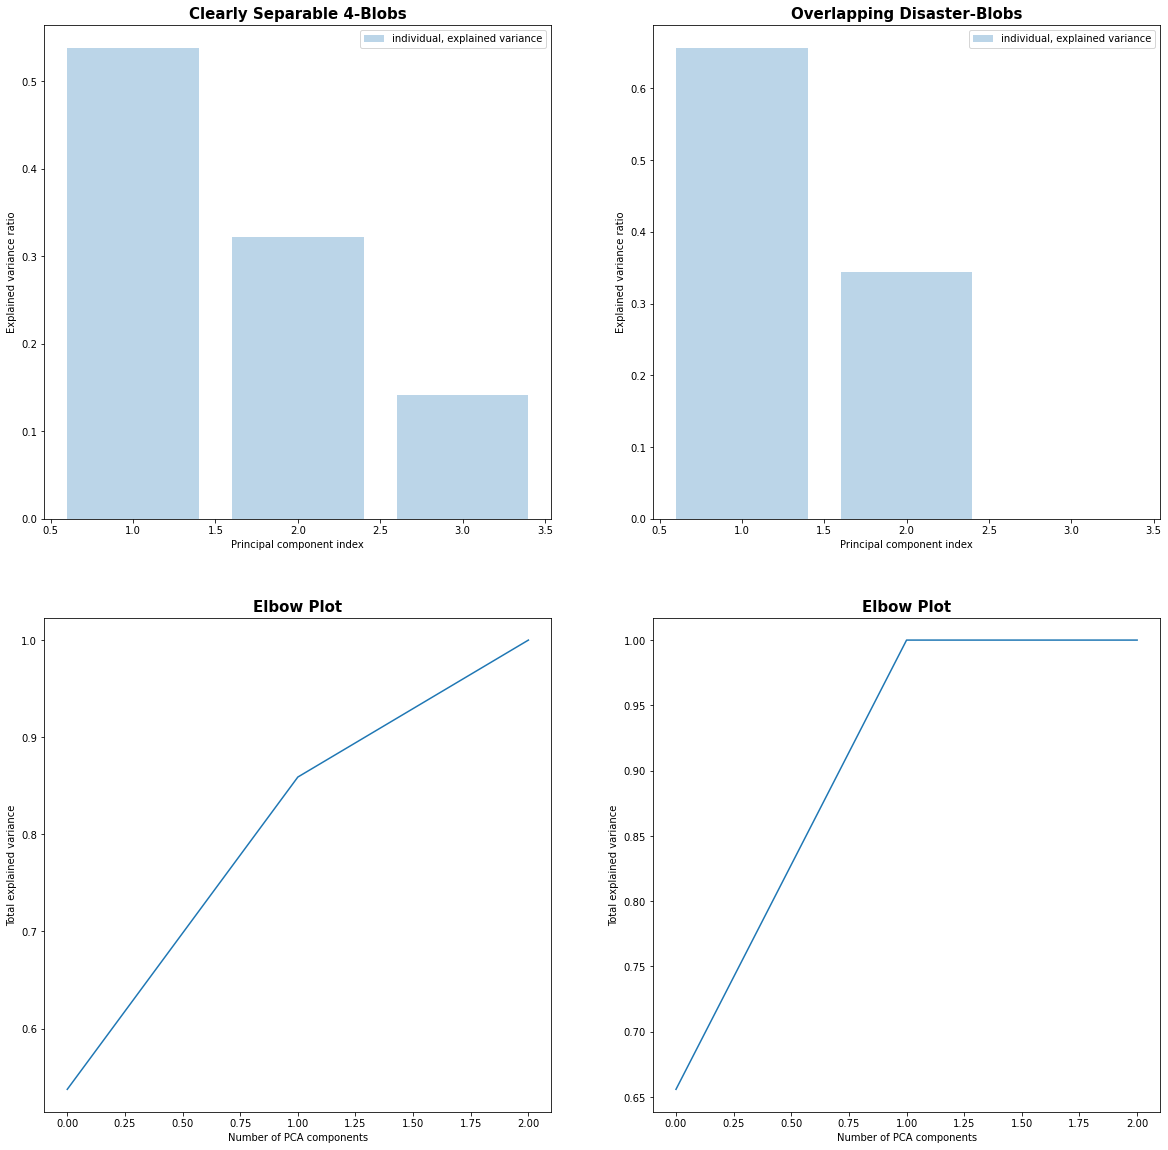

In [4]:
'''Plot explained variances'''

fig = plt.figure(figsize=(20,20)) # Plot size
'''First Plot'''
ax = fig.add_subplot(2, 2, 1) # Add first plot 
ax.set_title('Clearly Separable 4-Blobs', loc = 'center', fontsize = 15, fontweight = "bold")
ax.bar(range(1,4), var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal component index')
ax.legend(loc='best')

'''Second Plot'''
ax = fig.add_subplot(2, 2, 2) # Add second plot 
ax.set_title('Overlapping Disaster-Blobs', loc = 'center', fontsize = 15, fontweight = "bold")
ax.bar(range(1,4), var_exp1, alpha=0.3, 
        align='center', label='individual, explained variance')
ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal component index')
ax.legend(loc='best')

'''Third Plot (Elbow)'''
ax = fig.add_subplot(2, 2, 3) # Add third plot 
ax.plot(np.cumsum(var_exp))
ax.set_title('Elbow Plot', fontsize = 15,fontweight = "bold")
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('Total explained variance')

'''Fourth Plot (Elbow)'''
ax = fig.add_subplot(2, 2, 4) # Add fourth plot 
ax.plot(np.cumsum(var_exp1))
ax.set_title('Elbow Plot', fontsize = 15,fontweight = "bold")
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('Total explained variance')
plt.show()

#### Take Home Message:
The elbow plot displays how much variation each principal component captures from the data.
PC1 captures the most variation, PC2 — the second most, and so on. Each of them contributes some information of the data.

| Clearly Separable 4-Blobs | Overlapping Disaster-Blobs |
| :- | :- | 
| 3 PCs are obviously enough to fully describe the variance in the data since we have 3 dimensions in total. As the first two PCs already describe more than 80% of the variance, we continue with the usage of those two. | In this dataset 2 PCs are already enough to describe the whole variance. To also cover at least 80 % of the variation, we must use both PCs. |

At this point in time (looking only at these 4 graphes only) we can't really tell which distribution will allow better classification. Obviously with the distributions themselves plotted most people should see what the prefered one is. To be noted: In such low dimensional space those elbow plots tend to not have the biggest meaning. They do get more important as the count of dimensions increase

In [5]:
def plot_decision_regions(X, y, classifier, resolution=0.01):
    # Does not work....always....Setup marker generator and color map: FIXED!
    markers = ('s', 'v', 'o', 'p') 
    colors = ('r', 'b', 'g', 'y')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Z is the prediction of the class, given point in plane
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Z=f(xx1,yy1), plot classes in plane using color map but opaque
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot data points, given labels
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

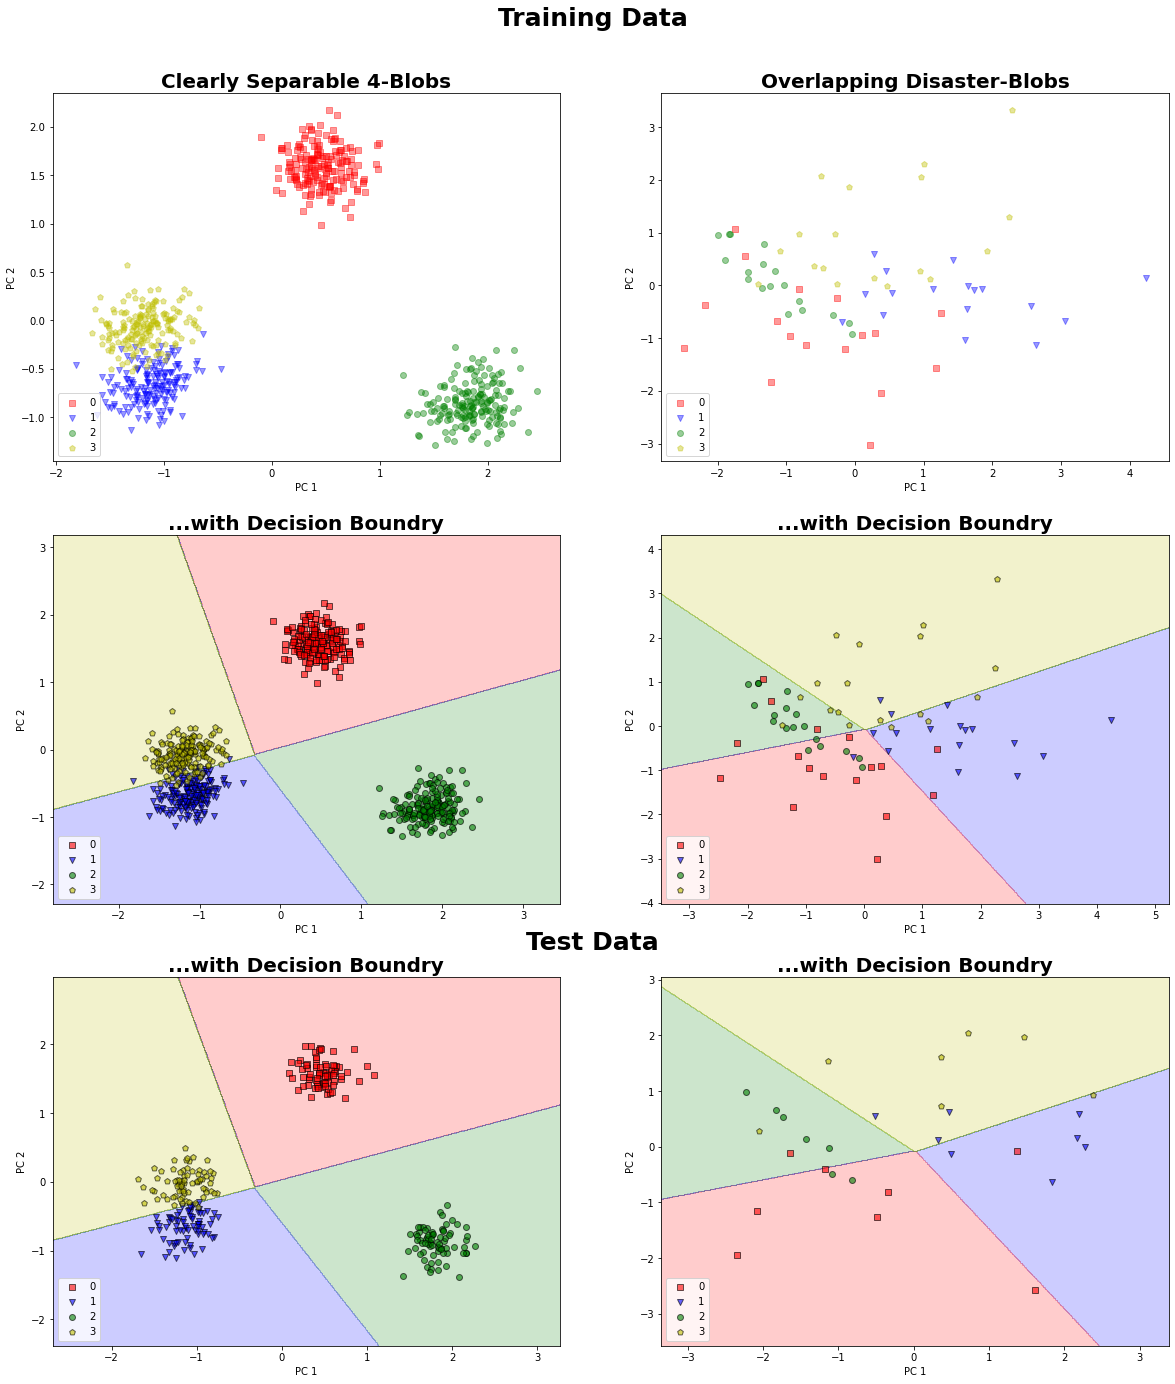

In [6]:
'''Plot the PCA space'''

markers = ('s', 'v', 'o', 'p') 
colors = ('r', 'b', 'g', 'y')
fig = plt.figure(figsize=(20,20)) # Plot size
fig.tight_layout() 
fig.subplots_adjust(top=0.92, bottom=0.05)
fig.suptitle('Training Data',fontsize = 25, fontweight = "bold")

'''First Plot'''
ax = fig.add_subplot(3, 2, 1) # Add first plot 
ax.set_title('Clearly Separable 4-Blobs', loc = 'center', fontsize = 20, fontweight = "bold")
for l, c, m in zip(np.unique(y_train), colors, markers):
    ax.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1], 
                color=c, label=l, marker=m, alpha=0.4) 
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

'''Second Plot'''
ax = fig.add_subplot(3, 2, 2) # Add second plot 
ax.set_title('Overlapping Disaster-Blobs', loc = 'center', fontsize = 20, fontweight = "bold")
for l, c, m in zip(np.unique(y_train), colors, markers):
    ax.scatter(X1_train_pca[y1_train==l, 0], # Pick x component for label
                X1_train_pca[y1_train==l, 1], 
                color=c, label=l, marker=m, alpha=0.4) 
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

'''Third Plot (Training Decision Boundry)'''
ax = fig.add_subplot(3, 2, 3) # Add third plot 
plot_decision_regions(X_train_pca, y_train, classifier=lr)
ax.set_title('...with Decision Boundry', loc = 'center', fontsize = 20, fontweight = "bold")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

'''Fourth Plot (Training Decision Boundry)'''
ax = fig.add_subplot(3, 2, 4) # Add fourth plot 
plot_decision_regions(X1_train_pca, y1_train, classifier=lr1)
ax.set_title('...with Decision Boundry', loc = 'center', fontsize = 20, fontweight = "bold")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

plt.figtext(0.5, 0.33, 'Test Data', ha='center', fontsize = 25, fontweight = "bold", va='center')

'''Fifth Plot (Test Decision Boundry)'''
ax = fig.add_subplot(3, 2, 5) # Add third plot 
plot_decision_regions(X_test_pca, y_test, classifier=lr)
ax.set_title('...with Decision Boundry', loc = 'center', fontsize = 20, fontweight = "bold")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

'''Sixth Plot (Test Decision Boundry)'''
ax = fig.add_subplot(3, 2, 6) # Add third plot 
plot_decision_regions(X1_test_pca, y1_test, classifier=lr1)
ax.set_title('...with Decision Boundry', loc = 'center', fontsize = 20, fontweight = "bold")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

plt.show()

In [7]:
# Accuracy Clearly Separable 4-Blobs
y_pred = lr.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.9933333333333333

In [8]:
# Accuracy Overlapping Disaster-Blobs
y1_pred = lr1.predict(X1_test_pca)
accuracy_score(y1_test, y1_pred)

0.7

#### Take Home Message:
| Clearly Separable 4-Blobs | Overlapping Disaster-Blobs |
| :- | :- | 
| The classifier performs really well in case of the cleary seperated datasets. Accuracy: 0.993. That was in deed to be expected but still it is worth mentionend that we don't really sacrifice much precision wiht reducing dimensions by 1/3| Classifier performs a bit worse in case of overlapping datasets. Accuracy: 0.7. Again, this was to be expected since the dataset shows a big overlap of the groups.|

Now here is where the difference between the two distributions is cleary visible. Furthermore, it is to be stated that in the disaster dataset there may be other to us unknown X's that could be introduced to enable a better classifier. Still, we expected the Classifier to perform worse in the disaster dataset.

___
**(b) 2 touching parabola spreads as shown in the lecture, but in 3d (not
2d). Study and show elbow plot and prediction boundaries.**


In [9]:
def touching_parabola(n_samples=1000, shuffle=True, noise=None, random_state=None):

    if isinstance(n_samples, numbers.Integral):
        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_out, n_samples_in = n_samples
        except ValueError as e:
            raise ValueError(
                "Please insert a number!"
            ) from e

    generator = check_random_state(random_state)

    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    outer_circ_z = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in)) - 1
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) + 1
    inner_circ_z = 1 - np.sin(np.linspace(0, np.pi, n_samples_out)) + 1

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y), 
         np.append(outer_circ_z, inner_circ_z)]
    ).T
    y = np.hstack(
        [np.zeros(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)]
    )

    if shuffle:
        X, y = util_shuffle(X, y, random_state=generator)

    if noise is not None:
        X += generator.normal(scale=noise, size=X.shape)

    return X, y


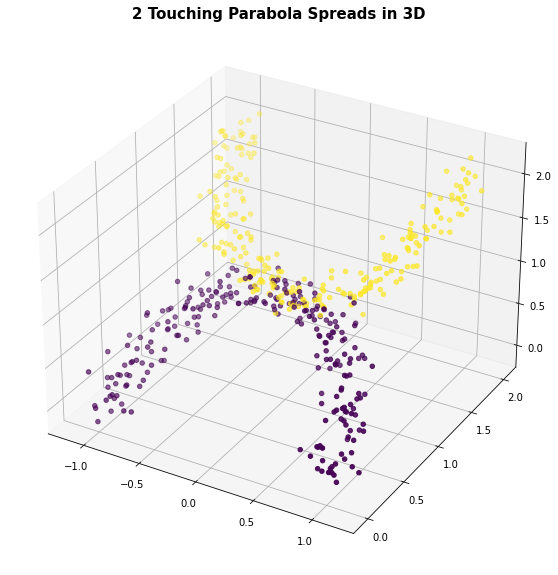

In [10]:
X, y = touching_parabola(n_samples=500, shuffle=True, noise=0.1, random_state=0)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection = '3d')
ax.set_title('2 Touching Parabola Spreads in 3D', loc = 'center', fontsize = 15, fontweight = "bold")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = y)
plt.show()

In [11]:
var_exp, X_train_pca, X_test_pca, y_train, y_test, lr = expVariance_pcaSpace(X, y)

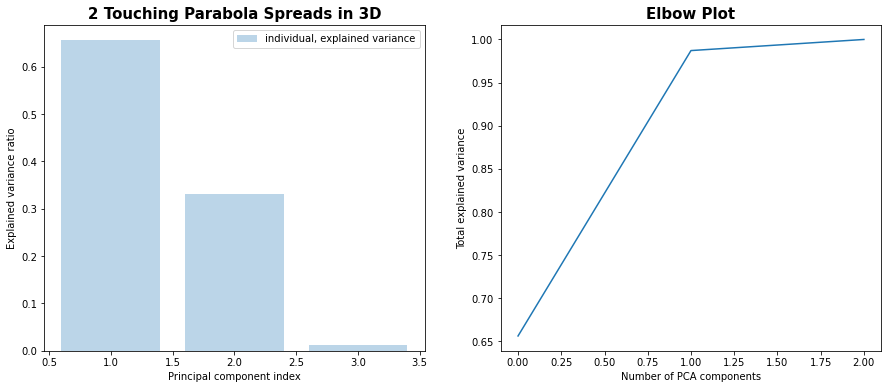

In [12]:
'''Plot explained variances'''

fig = plt.figure(figsize=(15,6)) # Plot size
'''First Plot'''
ax = fig.add_subplot(1, 2, 1) # Add first plot 
ax.set_title('2 Touching Parabola Spreads in 3D', loc = 'center', fontsize = 15, fontweight = "bold")
ax.bar(range(1,4), var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal component index')
ax.legend(loc='best')

'''Second Plot'''
ax = fig.add_subplot(1, 2, 2) # Add second plot 
ax.plot(np.cumsum(var_exp))
ax.set_title('Elbow Plot', fontsize = 15,fontweight = "bold")
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('Total explained variance')


plt.show()

#### Take Home Message:

The elbow plot displays how much variation each principal component captures from the data.
PC1 captures the most variation, PC2 — the second most, and so on. Each of them contributes some information of the data.

3 PCs are enough to fully describe the data (Reminder: 3 Dimensional Space). As the first two PCs already describes 98.7%  of the total variance, we continue with those two. 

Again, since we are in low dimensional space, these plots don't have a huge meaning/impact.

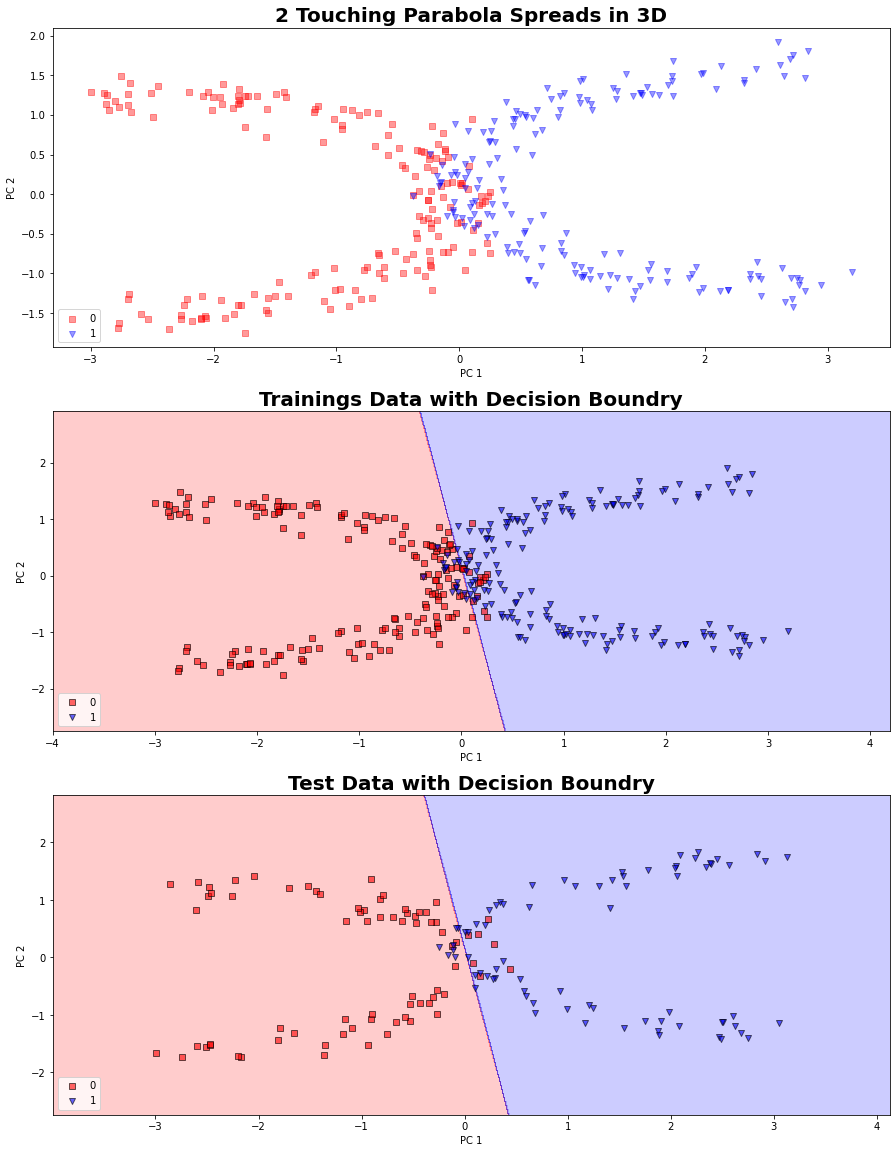

In [13]:
'''Plot the PCA space'''

colors = ['r', 'b', 'g']
markers = ['s', 'v', 'o']
fig = plt.figure(figsize=(15,20)) # Plot size
#fig.tight_layout() 
#fig.subplots_adjust(top=0.92, bottom=0.05)
#fig.suptitle('Training Data',fontsize = 25, fontweight = "bold")

'''First Plot'''
ax = fig.add_subplot(3, 1, 1) # Add first plot 
ax.set_title('2 Touching Parabola Spreads in 3D', loc = 'center', fontsize = 20, fontweight = "bold")
for l, c, m in zip(np.unique(y_train), colors, markers):
    ax.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1], 
                color=c, label=l, marker=m, alpha=0.4) 
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

'''Third Plot (Training Decision Boundry)'''
ax = fig.add_subplot(3, 1, 2) # Add third plot 
plot_decision_regions(X_train_pca, y_train, classifier=lr)
ax.set_title('Trainings Data with Decision Boundry', loc = 'center', fontsize = 20, fontweight = "bold")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

ax = fig.add_subplot(3, 1, 3) # Add third plot 
plot_decision_regions(X_test_pca, y_test, classifier=lr)
ax.set_title('Test Data with Decision Boundry', loc = 'center', fontsize = 20, fontweight = "bold")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend(loc='lower left')

In [14]:
# Accuracy Clearly Separable 4-Blobs
y_pred = lr.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.9

#### Take Home Message:
As we can see the classifier still is very capable of predicting the underlying class. This was to be expected by looking at the two distributions. Important note here: the distribitions themselves (meaning both classes seperatly) as well as both classes combined would have a Pearson coefficient around zero. One might think this indicates that we should not be able to classify in this case. Though, this is wrong! With a Pearson coefficient at zero we only have no linear correlation. There is still the possibilty of good separability as we have in this case.

## Random Projections

Based on the program developed in the lecture (SparseRandomProjections), analyze 2 databases of your choice (but not exactly the same digits
data as in the lecture) using random projections.

Study the accuracy (or a score of your choice that makes most sense for
your data) as a function of the number of dimensions / features that
survived the random projection.

Try to avoid a zick-zack curve below or around the baseline accuracy curve
as your final result for both datasets. At least for one dataset the score
is expected to be a smooth-ish curve as a function of the kept number of
features. **Provide a take-home statement and explain every step.**

You will find that data that is embedded in Eukledian spaces (such as
digits) may be more appropriate than data for which Eukledian distances
are not an excellent distance measure.

In [2]:
def SparseRandomProjections(data, dim, n):
    trainData, testData, trainTarget, testTarget = train_test_split(data.data, data.target, test_size = 0.3,
    random_state = 11)
    print("Professors Johnson and Lindenstrauss say: k >=", johnson_lindenstrauss_min_dim(dim,eps=0.1))
    
    model = LinearSVC()
    model.fit(trainData, trainTarget)
    baseline = accuracy_score(model.predict(testData), testTarget)
    accuracies = []
    dims = np.int32(np.linspace(2, dim, n))

    n_samples, n_features = data.data.shape
    # Loop over the projection sizes, k
    print(f"Embedding {n_samples} samples with dim {n_features} using various random projections")
    for dim in dims:
        # Create random projection
        sp = SparseRandomProjection(n_components = dim)
        X = sp.fit_transform(trainData)
        print(f"Projected {n_samples} samples from {n_features} to {dim}")

        # Train classifier of your choice on the sparse random projection
        model = LinearSVC()
        model.fit(X, trainTarget)

        # Evaluate model and update accuracies
        test = sp.transform(testData)
        accuracies.append(accuracy_score(model.predict(test), testTarget))
    
    # Create figure
    plt.figure(figsize=(15,6))
    plt.xlabel("# of dimensions k")
    plt.ylabel("Accuracy")
    plt.xlim([0, dim])
    plt.ylim([0, 1])

    # Plot baseline and random projection accuracies
    plt.plot(dims, [baseline] * len(accuracies), color = "r")
    plt.plot(dims, accuracies)

    plt.show()

Professors Johnson and Lindenstrauss say: k >= 10093
Embedding 11314 samples with dim 130107 using various random projections
Projected 11314 samples from 130107 to 2
Projected 11314 samples from 130107 to 9295
Projected 11314 samples from 130107 to 18588
Projected 11314 samples from 130107 to 27881
Projected 11314 samples from 130107 to 37174
Projected 11314 samples from 130107 to 46468
Projected 11314 samples from 130107 to 55761
Projected 11314 samples from 130107 to 65054
Projected 11314 samples from 130107 to 74347
Projected 11314 samples from 130107 to 83640
Projected 11314 samples from 130107 to 92934
Projected 11314 samples from 130107 to 102227
Projected 11314 samples from 130107 to 111520
Projected 11314 samples from 130107 to 120813
Projected 11314 samples from 130107 to 130107


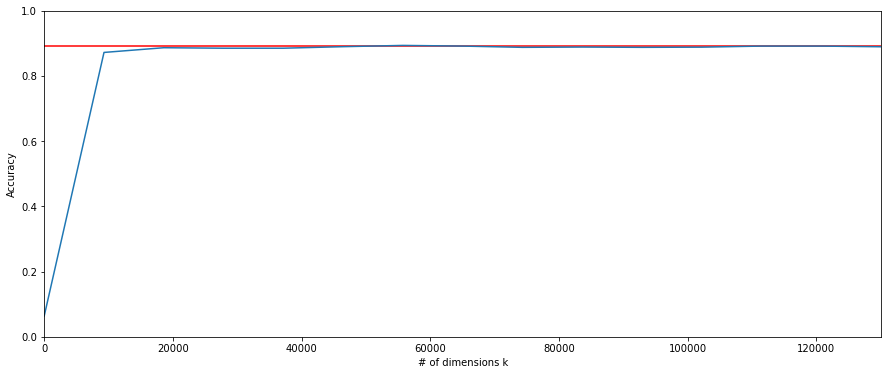

In [5]:
data = fetch_20newsgroups_vectorized()
SparseRandomProjections(data, 130107, 15)

#### Take Home Message:
Sparse Random Projection is a good way to reduce the complexity and size of data, helping us to process and visualize it. Compared to PCA it is way less computational expensive as the projection matrix is not computed with the eigenvectors instead they are selected randomly.
The 'fetch_20newsgroups_vectorized' is a high dimensional euklidean data set which helps to show a possible usecase of the Lemma by Johnson and Lindenstrauss: As we see the sugested number of dimensions (by this lemma) is way lower than the actual number of dimensions in this dataset. Thus, this number of dimensions 10093 would be a good starting point. As we can observe in the plot the Lemma seems to hold true (surprise, surpise), as the accuracy starts to reach a desireable level at around those 10093 dimensions.

#### Explain every step:
We first load the 'fetch_20newsgroups_vectorized' dataset and looked into its shape. It has n=11314 and k=130107.

Introducing the sample size in the Johnson Lindenstrauss lemma, it turns out that our minimum number of dimension k>=10093.

We decided to plot the acuarcy for a span of dimensions until the "full" dimension of 130107 to be able to better visualize that we don't see any zick-zack lines.

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/dennisblaufuss/scikit_learn_data
Professors Johnson and Lindenstrauss say: k >= 7129
Embedding 400 samples with dim 4096 using various random projections
Projected 400 samples from 4096 to 2
Projected 400 samples from 4096 to 294
Projected 400 samples from 4096 to 586
Projected 400 samples from 4096 to 879
Projected 400 samples from 4096 to 1171
Projected 400 samples from 4096 to 1464
Projected 400 samples from 4096 to 1756
Projected 400 samples from 4096 to 2049
Projected 400 samples from 4096 to 2341
Projected 400 samples from 4096 to 2633
Projected 400 samples from 4096 to 2926
Projected 400 samples from 4096 to 3218
Projected 400 samples from 4096 to 3511
Projected 400 samples from 4096 to 3803
Projected 400 samples from 4096 to 4096


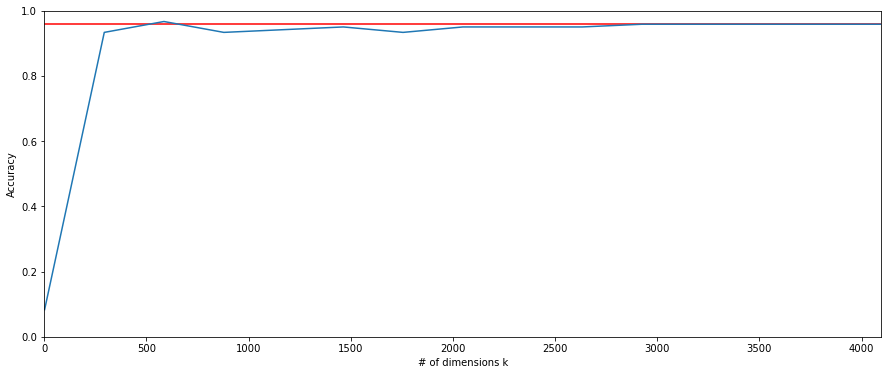

In [6]:
data = fetch_olivetti_faces()
SparseRandomProjections(data, 4096, 15)

#### Take Home Message:
Looking at the Johnson Lindenstrauss Lemma it can be observed that for small values of 'eps', 'd' is quite large but decreases as 'eps' aproaches one. This shows that applying Random Projections only makes sense to high-dimensional data, of the order of thousands of features. In such cases, a high reduction in dimensionality can be achieved.
Considering the Sugggestion of our two Proffessors: In this case the dimensionality might be too low for a Random Projection as we don't even have the by the Lemma suggested 7129 dimension in our dataset. 

Though, we still observe while looking at the accuracy graph, that with a k bigger than roughly 500 we achieve a desirable accuracy. Our main Take Home at this point would be as following (considering both datasets): If the Lemma suggest a k that is smaller than our actual dimension we definitly can use Sparse random projection to decrease the number of dimensions (obviosly given preconditions like kind of distance etc.) Furthermore, even if the Lemma suggests a k way higher than our d, we might still be able to have good results.

#### Explain every step:
We chose 'fetch_olivetti_faces' as our second dataset to showcase another dataset for possible (distance wise) sparse random projection use. Furthermore, we wanted to include a smaller one than the first one, primarily for computational reasons.

With introducing the steps mentioned above in a funciton the application of the "workflow" was pretty simple for the second dataset.